In [78]:
import torch
import torch.nn as nn
import importlib
import ES_classes
importlib.reload(ES_classes)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.autonotebook import tqdm

In [79]:
device = "cuda"

In [80]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = torch.from_numpy(x_train).to(device).reshape(-1, 784) / 255
y_train = torch.from_numpy(y_train).to(device).long()
x_test = torch.from_numpy(x_test).to(device).reshape(-1, 784) / 255
y_test = torch.from_numpy(y_test).to(device).long()

In [81]:
class Threshold(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.where(x > 0, 1., 0.)

In [134]:
mlp = ES_classes.ES_MLP(nn.Sequential(
    ES_classes.ES_Linear(784, 32),
    nn.ReLU(),
    ES_classes.ES_Linear(32, 32),
    nn.ReLU(),
    ES_classes.ES_Linear(32, 10),
)).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(reduction='none')

steps = 1_000
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/steps))

log = []

In [139]:
batch_size = 512
sigma = .05

bar = tqdm(range(1, steps+1))
for _ in bar:
    batch = torch.randperm(x_train.shape[0])[:batch_size].to(device)
    x_batch = x_train[batch]
    y_batch = y_train[batch]

    mlp.generate_epsilons(batch_size, sigma=sigma)
    y_pred = mlp(x_batch)
    losses = criterion(y_pred, y_batch)
    accs = (y_pred.argmax(-1) == y_batch).float()

    loss = losses.mean().item()
    acc = accs.mean().item()
    mlp.estimate_grads(losses, sigma=sigma)
    optimizer.step()
    # scheduler.step()
    
    # sigma -= .1 / steps

    e = {"loss":loss, "acc":acc}# , "lr":scheduler.get_last_lr()[0]}
    log.append(e)
    bar.set_postfix(e)

100%|██████████| 1000/1000 [02:22<00:00,  7.00it/s, loss=0.968, acc=0.68]


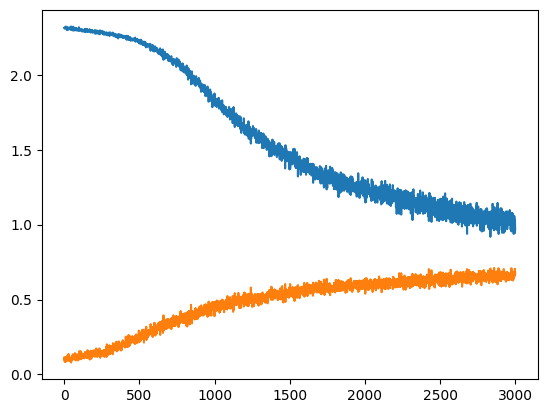

In [140]:
plt.plot([e["loss"] for e in log])
plt.plot([e["acc"] for e in log])
plt.show()

# plt.plot([e["sigma"] for e in log])
# plt.show()

In [371]:
def train(mlp, optimizer, epochs, alpha, sigma, N, mini_batch):
    bar = tqdm(range(1, epochs+1))

    history = {"Loss":[], "Acc":[]}

    with torch.no_grad():
        for _ in bar:
            # Grab batch
            batch = torch.randperm(x_train.shape[0])[:N].to(device)
            x_batch = x_train[batch]
            y_batch = y_train[batch]

            x = x_batch
            epsilon = []

            # Go through model but add random epsilon to weights at each step
            for layer in mlp:
                if isinstance(layer, nn.Linear):
                    # Make sure to have pairs of ep and -ep
                    e_w = torch.randn(N//(2*mini_batch), *layer.weight.T.shape).to(device)
                    e_w = torch.cat([e_w, -e_w], axis=0)
                    # Make minibatch copies of each ep
                    e_w = e_w.repeat(mini_batch, *((e_w.dim()-1)*[1]))

                    # Randomly fiddle with Weight matrix
                    new_w = expand_repeat(layer.weight.T, N, 0) + sigma*e_w

                    e_b = torch.randn(N//(2*mini_batch), *layer.bias.shape).to(device)
                    e_b = torch.cat([e_b, -e_b], axis=0)
                    # Make minibatch copies of each ep
                    e_b = e_b.repeat(mini_batch, *((e_b.dim()-1)*[1]))

                    # Randomly fiddle with Bias
                    new_b = expand_repeat(layer.bias, N, 0) + sigma*e_b
                    
                    x = (x.unsqueeze(1) @ new_w).squeeze(1) + new_b
                    
                    # Keep track of epsilons used
                    epsilon.append(e_w)
                    epsilon.append(e_b)

                else:
                    # If it has no params we don't care
                    x = layer(x)

            # Now get losses for each example individually (use square error for simplicity although technically should use crossentropy)
            losses = torch.square(x - nn.functional.one_hot(y_batch, 10)).mean(-1)

            # Now approximate gradient

            # LOOKING THROUGH OG ES PAPER IT SAYS DIVIDE BY SIGMA BUT THE PAPER WE'RE COPYING USED SIGMA**2.  
            # PROBS FINE WITH DIF LR SETTINGS
            grad_estimate = [(e * losses.reshape(-1, *((e.dim()-1)*[1]))).mean(0) / sigma for e in epsilon]


            optimizer.zero_grad()
            # Now take a step of gradient descent
            for p, grad in zip(mlp.parameters(), grad_estimate):
                p.grad = grad.T

            optimizer.step()

            loss = losses.mean().item()
            acc = (x.argmax(-1) == y_batch).float().mean().item()

            history["Loss"].append(loss)
            history["Acc"].append(acc)

            bar.set_postfix({"Loss":loss, "Acc":acc})

    return history

In [375]:
N = 8096
mini_batch = 1
alpha = .01
sigma = .1

mlp = nn.Sequential(
    nn.Linear(784, 16),
    nn.Sigmoid(),
    nn.Linear(16, 10),
    nn.Softmax(),
).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=alpha)

history = train(mlp, optimizer, 100_000, alpha, sigma, N, mini_batch)

  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\bunna\AppData\Local\Temp\ipykernel_16072\3057879116.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = layer(x)
  4%|▍         | 3867/100000 [32:45<13:34:30,  1.97it/s, Loss=0.0239, Acc=0.837]


KeyboardInterrupt: 

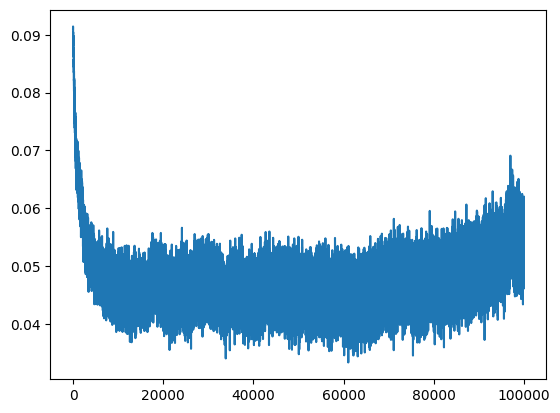

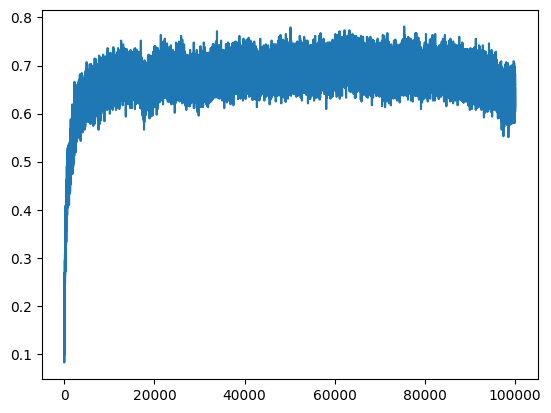

In [376]:
plt.plot(history["Loss"])
plt.show()
plt.plot(history["Acc"])
plt.show()

In [362]:
import time

In [365]:
# N = 1024
# mini_batch = 4
alpha = .01
sigma = .1
assert N % (2*mini_batch) == 0

# Grid search
histories = {}

for N in 2**np.arange(8, 12):
    histories[N] = {}
    for mini_batch in 2**np.arange(0, 1):

        mlp = nn.Sequential(
            nn.Linear(784, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
            nn.Softmax(),
        ).to(device)
        optimizer = torch.optim.Adam(mlp.parameters(), lr=alpha)

        t0 = time.time()
        while time.time() - t0 < 5:
            history = train(mlp, optimizer, 10, alpha, sigma, N, mini_batch)

        histories[N][mini_batch] = history
        
        # plt.title(f"N: {N} | MiniBatchSize {mini_batch}")
        # plt.plot(history["Loss"])
        # plt.plot(history["Acc"])
        # plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\bunna\AppData\Local\Temp\ipykernel_16072\3181676130.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = layer(x)
100%|██████████| 10/10 [00:01<00:00,  6.59it/s, Loss=0.0887, Acc=0.182]


<AxesSubplot:>

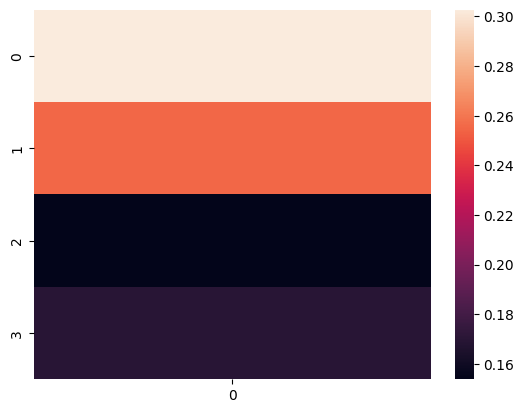

In [366]:
import seaborn as sb

heatmap = np.zeros((4, 1))

for i, N in enumerate(2**np.arange(8, 12)):
    for j, mini_batch in enumerate(2**np.arange(0, 1)):
        heatmap[i, j] = np.mean(histories[N][mini_batch]["Acc"][-50:])

sb.heatmap(heatmap)

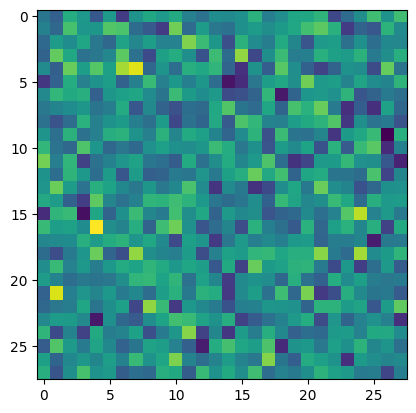

In [303]:
plt.imshow(mlp[0].weight[0].reshape(28, 28).cpu().detach())

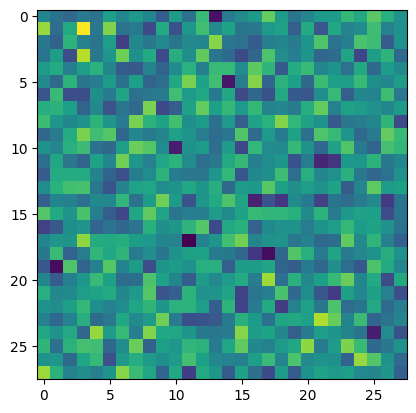

In [304]:
plt.imshow(grad_estimate[0][:, 0].reshape(28, 28).cpu())

In [ ]:
print(mlp[0].weight.shape)

torch.Size([16, 784])


In [120]:
print(expand_repeat(mlp[0].weight, N, 2).shape)

torch.Size([16, 784, 128])


In [109]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(784, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
        )
    
    def forward(self, x):
        with torch.no_grad():
            return self.main(x)

mlp = MLP().to(device)
n_params = sum(len(p.flatten()) for p in mlp.parameters())
sigma = .01
alpha = .01
N = 100

In [110]:
criterion = nn.CrossEntropyLoss()

In [111]:
min_batch_size = 8

def get_fitness(model):
    batch = torch.randperm(x_train.shape[0])[:min_batch_size].to(device)
    x = x_train[batch]
    y = y_train[batch]
    y_pred = model(x)
    return -criterion(y_pred, y)

In [112]:
def sample_epsilon(mlp):
    # Do once with +epsilon
    epsilon = [torch.randn(*p.shape).to(device) for p in mlp.parameters()]
    for p, e in zip(mlp.parameters(), epsilon):
        p.data += e*sigma

    pos_f = get_fitness(mlp)

    # Do once with -epsilon
    for p, e in zip(mlp.parameters(), epsilon):
        p.data -= 2*e*sigma

    neg_f = get_fitness(mlp)

    # Reset
    for p, e in zip(mlp.parameters(), epsilon):
        p.data += e*sigma

    return pos_f, neg_f, epsilon

In [113]:
EPOCHS = 10_000

bar = tqdm(range(1, EPOCHS+1))

for epoch in bar:
    grad_estimate = [torch.zeros_like(p.data).to(device) for p in mlp.parameters()]

    avg_fitness = 0

    for n in range(N//2):
        pos_f, neg_f, epsilon = sample_epsilon(mlp)

        for i in range(len(grad_estimate)):
            # This encapsilates adding + and - epsilon, weighted by their fitness
            grad_estimate[i] += (pos_f - neg_f) * epsilon[i] / (N//2 * sigma)

        avg_fitness += (pos_f + neg_f) / (N//2)

    for p, grad in zip(mlp.parameters(), grad_estimate):
        # Grad ascent since its fitness not loss
        p.data += alpha * grad

    bar.set_postfix({"Avg. Fitness":avg_fitness.item()})

  0%|          | 40/10000 [00:12<50:46,  3.27it/s, Avg. Fitness=-4.74] 


KeyboardInterrupt: 

In [ ]:
class ES_Linear(nn.Linear):
    def __init__(self, n_inps, n_outs, sigma=.1, **kwargs):
        super().__init__(n_inps, n_outs, **kwargs)
        self.sigma = sigma
        self.train_mode = True
        
    def generate_epsilons(self, batch_size):
        assert batch_size % 2 == 0, "In train mode batch size must be even so every +ep can have a -ep"
        epsilon_w = torch.randn(batch_size//2, *self.weight.shape)
        self.epsilon_w = torch.cat([epsilon_w, -epsilon_w], axis=0)

        epsilon_b = torch.randn(batch_size//2, *self.bias.shape)
        self.epsilon_b = torch.cat([epsilon_b, -epsilon_b], axis=0)
        return self.epsilon_w, self.epsilon_b

    def forward(self, x):
        if self.train_mode:
            # Factoring:
            # x @ (w.T + ep1) + (b + ep2)
            # To:
            # x @ w.T + x @ ep1 + b + ep2
            # So I don't have to repeat weight which is sorta wack
            return x @ self.weight.T + (x.unsqueeze(-2) @ torch.swapaxes(self.sigma * self.epsilon_w, -1, -2)).squeeze(-2) + self.bias + self.sigma * self.epsilon_b
        else:
            return x @ self.weight.T + self.bias

    def estimate_grads(self, losses):
        # Estimate gradients
        self.weight.grad = (self.epsilon_w * losses.reshape(-1, 1, 1)).mean(0) / self.sigma
        self.bias.grad = (self.epsilon_b * losses.reshape(-1, 1)).mean(0) / self.sigma


class ES_MLP(nn.Module):
    def __init__(self, sequential):
        super().__init__()
        self.sequential = sequential

    # Turn on train mode or eval mode
    def train_mode(self, flag):
        for layer in self.sequential:
            if isinstance(layer, ES_Linear):
                layer.train_mode = flag

    def generate_epsilons(self, batch_size):
        epsilons = []
        for layer in self.sequential:
            if isinstance(layer, ES_Linear):
                ep1, ep2 = layer.generate_epsilons(batch_size)
                epsilons.append(ep1)
                epsilons.append(ep2)
        return epsilons

    def forward(self, x):
        # Whatever we do its without explicit grad calcs
        with torch.no_grad():
            return self.sequential(x)
        
    def estimate_grads(self, losses):
        for layer in self.sequential:
            if isinstance(layer, ES_Linear):
                layer.estimate_grads(losses)